# Реализация Q-learning в Tensorflow 2.0

Задачу Q-learning из Coursera ([Practical Reinforcement Learning Неделя 4 Approximate Q-learning: CartPole](https://www.coursera.org/learn/practical-rl/notebook/pO7NP/approximate-q-learning-cartpole)) , в которой в шаблоне использовались элементы Tensorflow 1.0 (от одного вида placeholder и sess.run уже не хочется учиться) перевожу в простой и читаемый Tensorflow 2.0 (Keras)   вид. 
Получилось не только упростить агента, но и разобраться в особенности Q-learning

Основная проблема, которая возникла в моей версии реализации - что нейросеть получает на вход вектор состояния, а на выходе дает вектор с ценностью каждого действия для этого состояния. В то же время обучающий пример дает нам уточнение ценности только одного действия для исходного состояния. Остальные действия (значение остальных выходных нейронов) нам неизвестны. Как же применить обучение с учителем (tf.keras.model.fit) если из вектора Y известно "истинное" значение только для одного из нейронов?

Решение следелал следующее. 
1. Определяю предсказание нейросети Yp (все действия) для исходного состояния s (predict(s))
2. Вычисляю уточненную цель Qsa для предпринятого действия (одного)
3. В векторе Yp заменяю значение для предпринятого действия на Qsa
4. Запускаю fit(s,Yp) для исходного состояния s и подправленного вектора Yp. 

В результате оптимизатор как раз и сделает один шаг в уменьшении MSE между предсказанным и вычисленным значениями Qsa действия из примера.

Остальные параметры модели сохранил из решения исходной задачи (чтобы возможно было ставнить работоспособность). Текст исходной задачи (комментарии на английском) тоже сохранил (убрав под CENSORED ненужные части реализации в Tensorflow 1.0). Добавленные мной строки комментировал на русском.

Вывод - результаты работы нейросети в TF 1.0 и TF 2.0 совпали. Программа стала более чем на десяток строк короче.

# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
   
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week4_approx/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

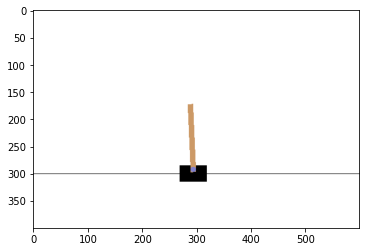

In [3]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`L.Dense`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [4]:
import tensorflow as tf
import keras
import keras.layers as L

#   CENSORED!!!!
# tf.reset_default_graph()
# sess = tf.InteractiveSession()
# keras.backend.set_session(sess)


Using TensorFlow backend.


In [0]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
network.add(L.Dense(64,activation="relu"))
network.add(L.Dense(128,activation="relu"))
network.add(L.Dense(64,activation="relu"))
network.add(L.Dense(n_actions))

optimizer = tf.keras.optimizers.Adam(lr=1e-4)   # строка добавлена как в шаблоне, чтобы проверить совпадение результатов

network.compile(loss='mse', optimizer=optimizer,  metrics=['mse'])  # строка добавлена


In [0]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    if np.random.rand()<epsilon:
        chosen_action=np.random.choice(len(q_values))
    else:
        chosen_action=np.argmax(q_values)


    return chosen_action

In [7]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [0]:
# CENSORED!!!!
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)

# states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
# actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
# rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
# next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim)
# is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

In [0]:

#     CENSORED!!!!
# #get q-values for all actions in current states
# predicted_qvalues = network(states_ph)

# #select q-values for chosen actions
# predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [0]:
gamma = 0.99

#  CENSORED!!!!

# # compute q-values for all actions in next states
# predicted_next_qvalues = network(next_states_ph)

# # compute V*(next_states) using predicted next q-values
# next_state_values = tf.reduce_max(predicted_next_qvalues,axis=1)

# # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
# target_qvalues_for_actions = rewards_ph+gamma*next_state_values

# # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
# target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [0]:
#    CENSORED!!!!
# #mean squared error loss to minimize
# loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
# loss = tf.reduce_mean(loss)

# # training function that resembles agent.update(state, action, reward, next_state) from tabular agent
# train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [0]:
#    CENSORED!!!!
# assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
# assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
# assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
# assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
# assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

### Playing the game (только здесь добавлял строки, в остальных местах лишь убирал)

In [0]:
#     CENSORED!!!!
# sess.run(tf.global_variables_initializer())

In [0]:
def generate_session(env, t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        if train:
  # CENSORED
  #           sess.run(train_step,{
  #               states_ph: [s], actions_ph: [a], rewards_ph: [r], 
  #               next_states_ph: [next_s], is_done_ph: [done]
  #           })

# А теперь добавляю код 
          if done:
            target=r # Если терминальое состояние то reward и есть ценой
          else:
            q_next_values = network.predict(next_s.reshape(1,-1))[0]    # иначе предсказываем  Q следующего состояния для всех действий       
            target=r+gamma*np.max(q_next_values,keepdims=True)          # и вычисляем цену текущей пары состояние-действие на основе награды и предполагаемой цены лучшего действия для следующего состояния

          q_values = network.predict(s.reshape(1,-1))[0]  # получаем текущее предположение нейросети о цене действий текущего состояния
          q_values[a]=target # подправляем одно значение Qsa на вычисленное. Как раз по нему и будет вычисляться MSE, так как Qsa остальных действий будут совпадать 

          network.fit(s.reshape(1,-1),q_values.reshape(1,-1),verbose=0)


        total_reward += r
        s = next_s
        if done:
            break
            
    return total_reward

In [0]:
epsilon = 0.5

In [17]:
for i in range(60):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 16.170	epsilon = 0.500
epoch #1	mean reward = 13.360	epsilon = 0.495
epoch #2	mean reward = 13.470	epsilon = 0.490
epoch #3	mean reward = 14.190	epsilon = 0.485
epoch #4	mean reward = 18.320	epsilon = 0.480
epoch #5	mean reward = 21.420	epsilon = 0.475
epoch #6	mean reward = 33.400	epsilon = 0.471
epoch #7	mean reward = 41.620	epsilon = 0.466
epoch #8	mean reward = 46.750	epsilon = 0.461
epoch #9	mean reward = 62.830	epsilon = 0.457
epoch #10	mean reward = 81.740	epsilon = 0.452
epoch #11	mean reward = 95.050	epsilon = 0.448
epoch #12	mean reward = 127.800	epsilon = 0.443
epoch #13	mean reward = 125.460	epsilon = 0.439
epoch #14	mean reward = 129.590	epsilon = 0.434
epoch #15	mean reward = 152.900	epsilon = 0.430
epoch #16	mean reward = 150.040	epsilon = 0.426
epoch #17	mean reward = 208.310	epsilon = 0.421
epoch #18	mean reward = 168.650	epsilon = 0.417
epoch #19	mean reward = 219.500	epsilon = 0.413
epoch #20	mean reward = 202.300	epsilon = 0.409
epoch #21	mean

Такими были результаты в Tensorflow 1.0

epoch #0	mean reward = 13.420	epsilon = 0.500

epoch #1	mean reward = 13.520	epsilon = 0.495

epoch #2	mean reward = 13.070	epsilon = 0.490

epoch #3	mean reward = 13.540	epsilon = 0.485

epoch #4	mean reward = 16.190	epsilon = 0.480

epoch #5	mean reward = 18.860	epsilon = 0.475

epoch #6	mean reward = 27.690	epsilon = 0.471

epoch #7	mean reward = 38.670	epsilon = 0.466

epoch #8	mean reward = 47.010	epsilon = 0.461

epoch #9	mean reward = 57.540	epsilon = 0.457

epoch #10	mean reward = 65.480	epsilon = 0.452

epoch #11	mean reward = 97.840	epsilon = 0.448

epoch #12	mean reward = 110.370	epsilon = 0.443

epoch #13	mean reward = 134.370	epsilon = 0.439

epoch #14	mean reward = 152.170	epsilon = 0.434

epoch #15	mean reward = 155.310	epsilon = 0.430

epoch #16	mean reward = 139.790	epsilon = 0.426

epoch #17	mean reward = 172.470	epsilon = 0.421

epoch #18	mean reward = 217.990	epsilon = 0.417

epoch #19	mean reward = 267.210	epsilon = 0.413

epoch #20	mean reward = 288.430	epsilon = 0.409

epoch #21	mean reward = 344.230	epsilon = 0.405

Моя простая модель Q-learning в Tensorflow 2.0 работает!